# 05 — Deep Learning: BiLSTM, BERT, dan Stacking Ensemble

Notebook ini menggunakan model **BiLSTM**, **BERT**, dan **Stacking Ensemble (BiLSTM + BERT)** untuk klasifikasi sentimen.

- **GPU wajib** (assert CUDA tersedia)
- **BiLSTM**: feature extraction menggunakan **Bag of Words (CountVectorizer)** → dipakai sebagai **vocabulary** untuk sequence
- **BERT**: **tanpa feature extraction manual** (langsung contextual embedding)
- **Stacking**: meta-learner Logistic Regression dari probabilitas output BiLSTM dan BERT

Silakan sesuaikan **nama file CSV berlabel** (variabel `INPUT_LABELED`) dengan nama file kamu.

In [1]:
import torch

print("CUDA available? :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name       :", torch.cuda.get_device_name(0))
else:
    print("Tidak ada GPU yang terdeteksi.")


CUDA available? : True
GPU name       : NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
import os, json, math, random, re
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

try:
    from torch.serialization import add_safe_globals
    add_safe_globals([np.core.multiarray.scalar])
except Exception as err:
    print("[PERINGATAN] Gagal allowlist numpy scalar untuk torch.load:", err)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

from tqdm.auto import tqdm
import sys

# Konfigurasi tqdm untuk tampilan lebih jelas
tqdm.pandas()

# ============================================================
# 1) Setup: seeding & device (wajib GPU)
# ============================================================

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

assert torch.cuda.is_available(), "GPU CUDA tidak terdeteksi. Pilih runtime GPU sebelum menjalankan notebook ini."
device = torch.device("cuda")
print("Device:", device)
print(f"Python environment: {sys.executable}")


C:\Users\Richie\AppData\Local\Temp\ipykernel_31552\320037106.py:12: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  add_safe_globals([np.core.multiarray.scalar])


Device: cuda
Python environment: c:\ProgramData\anaconda3\python.exe


In [4]:
# ============================================================
# 2) Load data & bagi train/test (window waktu 2024)
#    SESUAIKAN INPUT_LABELED dgn file CSV berlabel kamu
# ============================================================

INPUT_LABELED = "reddit_opinion_PSE_ISR_2024_window_labeled_textblob.csv"  # <-- ganti kalau nama file beda
ALL_LABELS = ["Positif", "Netral", "Negatif"]
TEXT_PREF  = ["final_text", "self_text"]

# Setup direktori untuk menyimpan artefak
ARTE_DL_DIR = Path("artefacts_2024_window_deep")
ARTE_DL_DIR.mkdir(exist_ok=True)

assert os.path.exists(INPUT_LABELED), f"Tidak ditemukan: {INPUT_LABELED}"
df = pd.read_csv(INPUT_LABELED, low_memory=False)

TEXT_COL = next((c for c in TEXT_PREF if c in df.columns and df[c].notna().any()), None)
assert TEXT_COL is not None, "Tidak ada kolom teks valid (final_text/self_text)."

if "month" not in df.columns:
    assert "created_time" in df.columns, "Butuh created_time atau month."
    df["created_time"] = pd.to_datetime(df["created_time"])
    df["month"] = df["created_time"].dt.to_period("M").astype(str)

df = df[df["label"].isin(ALL_LABELS)].copy()
df["text"] = df[TEXT_COL].astype(str).str.strip()
df = df[df["text"] != ""].copy()

train_months = [f"2024-{m:02d}" for m in range(1, 11)]  # Jan–Okt
test_months  = ["2024-11", "2024-12"]                  # Nov–Des

df_tr = df[df["month"].isin(train_months)].copy()
df_te = df[df["month"].isin(test_months)].copy()

print(f"Train rows: {len(df_tr):,} | Test rows: {len(df_te):,}")
print("Train label dist:\n", df_tr["label"].value_counts())
print("\nTest label dist:\n",  df_te["label"].value_counts())

label2id = {lab: i for i, lab in enumerate(ALL_LABELS)}
id2label = {i: lab for lab, i in label2id.items()}

df_tr["label_id"] = df_tr["label"].map(label2id)
df_te["label_id"] = df_te["label"].map(label2id)

X_train, X_val, y_train, y_val = train_test_split(
    df_tr["text"].values,
    df_tr["label_id"].values,
    test_size=0.1,
    random_state=SEED,
    stratify=df_tr["label_id"].values,
)

X_test = df_te["text"].values
y_test = df_te["label_id"].values

print("\nSplit:")
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Train rows: 493,903 | Test rows: 64,941
Train label dist:
 label
Netral     229249
Positif    154622
Negatif    110032
Name: count, dtype: int64

Test label dist:
 label
Netral     30622
Positif    20329
Negatif    13990
Name: count, dtype: int64

Split:
Train: 444512 Val: 49391 Test: 64941



[BiLSTM] Vocab size (BOW): 22212

✅ [BiLSTM] MODEL SUDAH ADA, LOADING DARI FILE...
[BiLSTM] Loaded - Test Accuracy: 0.9797 | Macro-F1: 0.9798


BiLSTM Test Prediction:   0%|                              | 0/1015 [00:00<?, ?batch/s]                       …


[BiLSTM] Classification report (Test):
              precision    recall  f1-score   support

     Positif     0.9815    0.9815    0.9815     20329
      Netral     0.9789    0.9787    0.9788     30622
     Negatif     0.9789    0.9793    0.9791     13990

    accuracy                         0.9797     64941
   macro avg     0.9798    0.9798    0.9798     64941
weighted avg     0.9797    0.9797    0.9797     64941



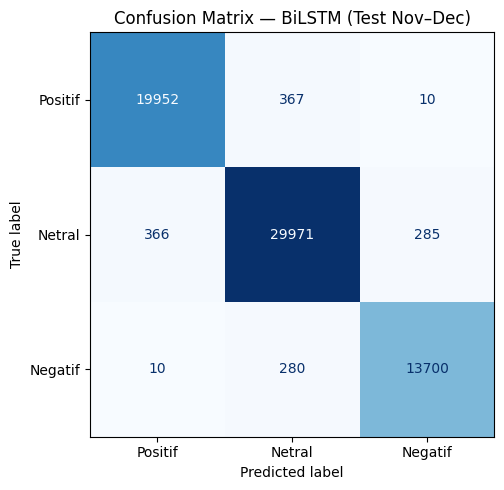

In [5]:
# ============================================================
# 3) BiLSTM dengan Bag-of-Words vocabulary (CountVectorizer)
#    BOW dipakai sebagai feature extraction utk vocab & sequence
# ============================================================

MAX_LEN_LSTM = 128
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 1
DROPOUT = 0.3
BATCH_SIZE_LSTM = 64
EPOCHS_LSTM = 5

# Path file untuk menyimpan hasil BiLSTM
BILSTM_MODEL_PATH = ARTE_DL_DIR / "bilstm_bow_model.pt"
BILSTM_RESULTS_PATH = ARTE_DL_DIR / "bilstm_results.json"

bow_cfg = dict(
    lowercase=True,
    ngram_range=(1, 1),
    min_df=5,
    max_df=0.9,
    max_features=40_000,
)

# Feature extraction: Bag-of-Words
bow_vect = CountVectorizer(**bow_cfg)
bow_vect.fit(df_tr["text"].values)

print("\n[BiLSTM] Vocab size (BOW):", len(bow_vect.vocabulary_))

analyzer = bow_vect.build_analyzer()
word2idx = {tok: (idx + 1) for tok, idx in bow_vect.vocabulary_.items()}
VOCAB_SIZE = len(word2idx) + 1  # +1 utk padding=0

def text_to_seq(text, max_len=MAX_LEN_LSTM):
    tokens = analyzer(text)
    seq = [word2idx[t] for t in tokens if t in word2idx]
    if len(seq) == 0:
        seq = [0]
    if len(seq) > max_len:
        seq = seq[:max_len]
    else:
        seq = seq + [0] * (max_len - len(seq))
    return np.array(seq, dtype=np.int64)

class BiLSTMDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = list(texts)
        self.labels = list(labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        seq = text_to_seq(self.texts[idx])
        label = self.labels[idx]
        return {
            "input_ids": torch.tensor(seq, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_ds_lstm = BiLSTMDataset(X_train, y_train)
val_ds_lstm   = BiLSTMDataset(X_val, y_val)
test_ds_lstm  = BiLSTMDataset(X_test, y_test)

train_loader_lstm = DataLoader(train_ds_lstm, batch_size=BATCH_SIZE_LSTM, shuffle=True,  num_workers=0, pin_memory=False)
val_loader_lstm   = DataLoader(val_ds_lstm,   batch_size=BATCH_SIZE_LSTM, shuffle=False, num_workers=0, pin_memory=False)
test_loader_lstm  = DataLoader(test_ds_lstm,  batch_size=BATCH_SIZE_LSTM, shuffle=False, num_workers=0, pin_memory=False)

class BiLSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=1, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, labels=None):
        emb = self.embedding(input_ids)
        output, (hn, cn) = self.lstm(emb)
        h_cat = torch.cat((hn[-2], hn[-1]), dim=1)
        logits = self.fc(self.dropout(h_cat))
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return logits, loss

lstm_model = BiLSTMSentiment(
    VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM,
    num_classes=len(ALL_LABELS),
    num_layers=NUM_LAYERS, dropout=DROPOUT,
).to(device)

def run_epoch_lstm(model, data_loader, optimizer=None, scheduler=None, desc=""):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    # Progress bar dengan format yang lebih jelas dan informatif
    pbar = tqdm(
        data_loader, 
        desc=desc,
        leave=True,
        ncols=120,
        bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
        colour='green' if not is_train else 'blue'
    )
    
    batch_losses = []
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            logits, loss = model(input_ids=input_ids, labels=labels)
            if is_train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.detach().cpu().numpy().tolist())
        all_labels.extend(labels.detach().cpu().numpy().tolist())
        
        batch_losses.append(loss.item())
        avg_batch_loss = np.mean(batch_losses[-10:])  # Rata-rata 10 batch terakhir
        
        # Update progress bar dengan info lebih detail
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "avg_loss": f"{avg_batch_loss:.4f}",
            "batch": f"{len(batch_losses)}/{len(data_loader)}"
        })

    avg_loss = total_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1m = f1_score(all_labels, all_preds, average="macro")
    return avg_loss, acc, f1m

def predict_proba_lstm(model, data_loader, desc="Predicting"):
    model.eval()
    all_probs = []
    with torch.no_grad():
        pbar = tqdm(
            data_loader, 
            desc=desc, 
            leave=True,
            ncols=120,
            bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
            colour='cyan',
            unit='batch'
        )
        for i, batch in enumerate(pbar, 1):
            input_ids = batch["input_ids"].to(device)
            logits, _ = model(input_ids=input_ids, labels=None)
            probs = torch.softmax(logits, dim=-1)
            all_probs.append(probs.detach().cpu().numpy())
            pbar.set_postfix({"processed": f"{i}/{len(data_loader)}"})
    return np.concatenate(all_probs, axis=0)

# ============================================================
# Cek apakah model BiLSTM sudah ada, jika ya load, jika tidak train
# ============================================================

if BILSTM_MODEL_PATH.exists() and BILSTM_RESULTS_PATH.exists():
    print("\n" + "="*60)
    print("✅ [BiLSTM] MODEL SUDAH ADA, LOADING DARI FILE...")
    print("="*60)
    checkpoint = torch.load(BILSTM_MODEL_PATH, map_location=device, weights_only=False)
    lstm_model.load_state_dict(checkpoint["state_dict"])
    
    with open(BILSTM_RESULTS_PATH, "r") as f:
        bilstm_results = json.load(f)
    
    test_acc_lstm = bilstm_results["test_accuracy"]
    test_f1_lstm = bilstm_results["test_f1"]
    
    print(f"[BiLSTM] Loaded - Test Accuracy: {test_acc_lstm:.4f} | Macro-F1: {test_f1_lstm:.4f}")
    
else:
    print("\n" + "="*60)
    print("🚀 [BiLSTM] MODEL BELUM ADA, MULAI TRAINING...")
    print("="*60)
    
    lr_lstm = 2e-3
    optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=lr_lstm)
    total_steps_lstm = EPOCHS_LSTM * len(train_loader_lstm)
    scheduler_lstm = get_linear_schedule_with_warmup(
        optimizer_lstm,
        num_warmup_steps=int(0.1 * total_steps_lstm),
        num_training_steps=total_steps_lstm,
    )
    
    best_val_f1 = 0.0
    best_lstm_state = None
    
    # Progress bar untuk epoch training BiLSTM
    epoch_pbar = tqdm(
        range(1, EPOCHS_LSTM + 1), 
        desc="📊 BiLSTM Training Progress",
        ncols=120,
        bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
        colour='magenta',
        unit='epoch'
    )
    
    for epoch in epoch_pbar:
        train_loss, train_acc, train_f1 = run_epoch_lstm(
            lstm_model, train_loader_lstm, optimizer_lstm, scheduler_lstm,
            desc=f"BiLSTM Epoch {epoch}/{EPOCHS_LSTM} [Train]"
        )
        val_loss, val_acc, val_f1 = run_epoch_lstm(
            lstm_model, val_loader_lstm, optimizer=None, scheduler=None,
            desc=f"BiLSTM Epoch {epoch}/{EPOCHS_LSTM} [Val]"
        )
        
        epoch_pbar.set_postfix({
            "train_f1": f"{train_f1:.4f}",
            "val_f1": f"{val_f1:.4f}",
            "best_val_f1": f"{best_val_f1:.4f}"
        })
        
        print(
            f"[BiLSTM][Epoch {epoch}] "
            f"Train loss {train_loss:.4f} | acc {train_acc:.4f} | F1 {train_f1:.4f} || "
            f"Val loss {val_loss:.4f} | acc {val_acc:.4f} | F1 {val_f1:.4f}"
        )
    
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_lstm_state = lstm_model.state_dict().copy()
    
    if best_lstm_state is not None:
        lstm_model.load_state_dict(best_lstm_state)
    
    # Evaluasi pada test set
    print("\n[BiLSTM] Evaluasi pada Test set...")
    test_loss_lstm, test_acc_lstm, test_f1_lstm = run_epoch_lstm(
        lstm_model, test_loader_lstm, optimizer=None, scheduler=None,
        desc="BiLSTM Test Evaluation"
    )
    print(f"[BiLSTM] Test Accuracy: {test_acc_lstm:.4f} | Macro-F1: {test_f1_lstm:.4f}")
    
    # Simpan model dan hasil
    print(f"\n💾 [BiLSTM] Menyimpan model ke {BILSTM_MODEL_PATH}...")
    torch.save({
        "state_dict": lstm_model.state_dict(),
        "bow_cfg": bow_cfg,
        "word2idx": word2idx,
        "max_len_lstm": MAX_LEN_LSTM,
        "label2id": label2id,
    }, BILSTM_MODEL_PATH)
    
    bilstm_results = {
        "test_accuracy": float(test_acc_lstm),
        "test_f1": float(test_f1_lstm),
        "best_val_f1": float(best_val_f1)
    }
    
    with open(BILSTM_RESULTS_PATH, "w") as f:
        json.dump(bilstm_results, f, indent=2)
    
    print("="*60)
    print("✅ [BiLSTM] MODEL DAN HASIL TERSIMPAN!")
    print("="*60)

# Prediksi dan evaluasi detail
proba_test_lstm = predict_proba_lstm(lstm_model, test_loader_lstm, desc="BiLSTM Test Prediction")
pred_test_lstm = proba_test_lstm.argmax(axis=1)

print("\n[BiLSTM] Classification report (Test):")
print(classification_report(
    y_test, pred_test_lstm,
    target_names=ALL_LABELS, digits=4, zero_division=0,
))

cm_lstm = confusion_matrix(y_test, pred_test_lstm,
                           labels=list(range(len(ALL_LABELS))))
disp_lstm = ConfusionMatrixDisplay(cm_lstm, display_labels=ALL_LABELS)
fig, ax = plt.subplots(figsize=(5.6, 5))
disp_lstm.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix — BiLSTM (Test Nov–Dec)")
plt.tight_layout()
plt.show()



[BERT] ✓ Model/tokenizer sudah ada, loading tokenizer dari file...

✅ [BERT] MODEL SUDAH ADA, LOADING DARI FILE...
[BERT] Loaded - Test Accuracy (saved): 0.9856 | Macro-F1: 0.9857


Encoding BERT test set (existing model):   0%|                                                | 0/32 [00:00<?,…

BERT Test Prediction:   0%|                              | 0/4059 [00:00<?, ?batch/s]                         …


[BERT] Classification report (Test):
              precision    recall  f1-score   support

     Positif     0.9840    0.9886    0.9863     20329
      Netral     0.9874    0.9832    0.9853     30622
     Negatif     0.9841    0.9866    0.9854     13990

    accuracy                         0.9856     64941
   macro avg     0.9852    0.9861    0.9857     64941
weighted avg     0.9856    0.9856    0.9856     64941



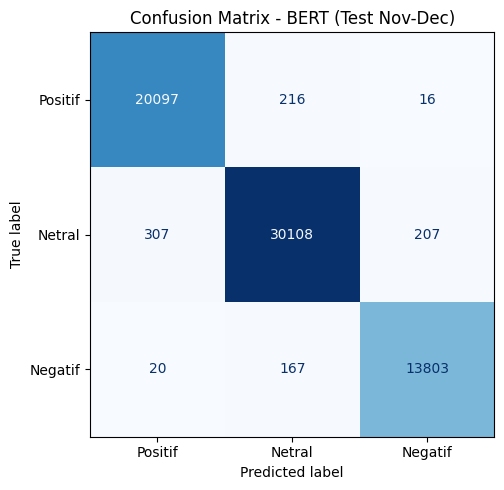

In [17]:
# ============================================================
# 4) BERT fine-tuning 
# ============================================================

MODEL_NAME = "bert-base-uncased"  # ganti ke IndoBERT kalau ingin model Indonesia

# Path file untuk menyimpan hasil BERT
BERT_MODEL_DIR = ARTE_DL_DIR / "bert_model"
BERT_TOKENIZER_DIR = ARTE_DL_DIR / "bert_tokenizer"
BERT_RESULTS_PATH = ARTE_DL_DIR / "bert_results.json"

MAX_LEN_BERT = 128
BATCH_SIZE_BERT = 16
EPOCHS_BERT = 3
LR_BERT = 2e-5

# --- cek apakah model sudah ada ---
MODEL_EXISTS = (
    BERT_MODEL_DIR.exists()
    and BERT_TOKENIZER_DIR.exists()
    and BERT_RESULTS_PATH.exists()
)

# tokenizer harus selalu ada (baik train maupun load)
if MODEL_EXISTS:
    print("\n[BERT] ✓ Model/tokenizer sudah ada, loading tokenizer dari file...")
    tokenizer = AutoTokenizer.from_pretrained(BERT_TOKENIZER_DIR)
else:
    print("\n[BERT] Model belum ada, gunakan tokenizer dari model base...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ============================================================
# Fungsi encoding + Dataset + helper prediksi (selalu tersedia)
# ============================================================

def encode_texts(texts, desc="Encoding BERT texts"):
    texts = list(texts)
    total = len(texts)
    if total == 0:
        return {
            "input_ids": torch.empty((0, MAX_LEN_BERT), dtype=torch.long),
            "attention_mask": torch.empty((0, MAX_LEN_BERT), dtype=torch.long),
        }

    chunk_size = 2048
    progress_desc = desc or "Encoding BERT texts"
    iterator = range(0, total, chunk_size)
    pbar = tqdm(iterator, desc=progress_desc, ncols=120, unit="chunk")
    input_ids_chunks = []
    attn_mask_chunks = []
    for start in pbar:
        batch_texts = texts[start:start + chunk_size]
        encoded = tokenizer(
            batch_texts,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN_BERT,
            return_tensors="pt",
        )
        input_ids_chunks.append(encoded["input_ids"])
        attn_mask_chunks.append(encoded["attention_mask"])

    return {
        "input_ids": torch.cat(input_ids_chunks, dim=0),
        "attention_mask": torch.cat(attn_mask_chunks, dim=0),
    }

class BertDataset(Dataset):
    def __init__(self, texts, labels, desc=None):
        enc = encode_texts(texts, desc=desc)
        self.input_ids = enc["input_ids"]
        self.attn_mask = enc["attention_mask"]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attn_mask[idx],
            "labels": self.labels[idx],
        }

def predict_proba_bert(model, data_loader, desc="Predicting"):
    model.eval()
    all_probs = []
    with torch.no_grad():
        pbar = tqdm(
            data_loader, 
            desc=desc,
            leave=True,
            ncols=120,
            bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
            colour='cyan',
            unit='batch'
        )
        for i, batch in enumerate(pbar, 1):
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attn_mask)
            probs = torch.softmax(outputs.logits, dim=-1)
            all_probs.append(probs.detach().cpu().numpy())
            pbar.set_postfix({"processed": f"{i}/{len(data_loader)}"})
    if len(all_probs) == 0:
        return np.zeros((0, len(ALL_LABELS)), dtype=np.float32)
    return np.concatenate(all_probs, axis=0)

# ============================================================
#  Cek model: load kalau sudah ada, kalau tidak siapkan training
# ============================================================

if MODEL_EXISTS:
    # ========================
    # CASE 1: model sudah ada
    # ========================
    print("\n" + "="*60)
    print("✅ [BERT] MODEL SUDAH ADA, LOADING DARI FILE...")
    print("="*60)

    bert_model = AutoModelForSequenceClassification.from_pretrained(
        BERT_MODEL_DIR
    ).to(device)

    with open(BERT_RESULTS_PATH, "r") as f:
        bert_results = json.load(f)

    test_acc_bert = bert_results["test_accuracy"]
    test_f1_bert = bert_results["test_f1"]

    print(f"[BERT] Loaded - Test Accuracy (saved): {test_acc_bert:.4f} | Macro-F1: {test_f1_bert:.4f}")

    # Untuk evaluasi ulang: cukup encode test set
    test_ds_bert = BertDataset(X_test, y_test, desc="Encoding BERT test set (existing model)")
    test_loader_bert = DataLoader(
        test_ds_bert,
        batch_size=BATCH_SIZE_BERT,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available(),
    )

else:
    # =========================
    # CASE 2: model belum ada
    # =========================
    print("\n" + "="*60)
    print("🚀 [BERT] MODEL BELUM ADA, MULAI TRAINING...")
    print("="*60)

    # dataset & loader untuk train/val/test
    train_ds_bert = BertDataset(X_train, y_train, desc="Encoding BERT train set")
    val_ds_bert   = BertDataset(X_val,   y_val,   desc="Encoding BERT validation set")
    test_ds_bert  = BertDataset(X_test,  y_test,  desc="Encoding BERT test set")

    train_loader_bert = DataLoader(
        train_ds_bert, batch_size=BATCH_SIZE_BERT,
        shuffle=True, num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    val_loader_bert = DataLoader(
        val_ds_bert, batch_size=BATCH_SIZE_BERT,
        shuffle=False, num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    test_loader_bert = DataLoader(
        test_ds_bert, batch_size=BATCH_SIZE_BERT,
        shuffle=False, num_workers=0,
        pin_memory=torch.cuda.is_available()
    )

    bert_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(ALL_LABELS),
        id2label={i: lab for i, lab in enumerate(ALL_LABELS)},
        label2id={lab: i for i, lab in enumerate(ALL_LABELS)},
    ).to(device)

    optimizer_bert = torch.optim.AdamW(bert_model.parameters(), lr=LR_BERT)
    total_steps_bert = EPOCHS_BERT * len(train_loader_bert)
    scheduler_bert = get_linear_schedule_with_warmup(
        optimizer_bert,
        num_warmup_steps=int(0.1 * total_steps_bert),
        num_training_steps=total_steps_bert,
    )

    def run_epoch_bert(model, data_loader, optimizer=None, scheduler=None, desc=""):
        is_train = optimizer is not None
        model.train() if is_train else model.eval()
        total_loss = 0.0
        all_preds = []
        all_labels = []

        progress_desc = desc or ("BERT Train" if is_train else "BERT Eval")
        pbar = tqdm(
            data_loader,
            desc=progress_desc,
            leave=True,
            ncols=120,
            bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
            colour='yellow' if is_train else 'green',
        )

        batch_losses = []
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            if is_train:
                optimizer.zero_grad()

            with torch.set_grad_enabled(is_train):
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attn_mask,
                    labels=labels,
                )
                loss = outputs.loss
                logits = outputs.logits

                if is_train:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    if scheduler is not None:
                        scheduler.step()

            total_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.detach().cpu().numpy().tolist())
            all_labels.extend(labels.detach().cpu().numpy().tolist())

            batch_losses.append(loss.item())
            avg_batch_loss = np.mean(batch_losses[-10:])
            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "avg_loss": f"{avg_batch_loss:.4f}",
                "seen": len(batch_losses),
            })

        dataset_size = len(data_loader.dataset)
        if dataset_size == 0:
            return 0.0, 0.0, 0.0

        avg_loss = total_loss / dataset_size
        acc = accuracy_score(all_labels, all_preds)
        f1m = f1_score(all_labels, all_preds, average="macro")
        return avg_loss, acc, f1m

    # --------------------- TRAINING LOOP ---------------------
    best_val_f1_bert = 0.0
    best_bert_state = None
    print("\n" + "="*60)
    print("🔥 [BERT] TRAINING DIMULAI...")
    print("="*60)
    epoch_pbar_bert = tqdm(
        range(1, EPOCHS_BERT + 1),
        desc="🔥 BERT Training Progress",
        ncols=120,
        bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
        colour='yellow',
        unit='epoch'
    )

    for epoch in epoch_pbar_bert:
        train_loss, train_acc, train_f1 = run_epoch_bert(
            bert_model,
            train_loader_bert,
            optimizer_bert,
            scheduler_bert,
            desc=f"BERT Epoch {epoch}/{EPOCHS_BERT} [Train]",
        )
        val_loss, val_acc, val_f1 = run_epoch_bert(
            bert_model,
            val_loader_bert,
            optimizer=None,
            scheduler=None,
            desc=f"BERT Epoch {epoch}/{EPOCHS_BERT} [Val]",
        )

        epoch_pbar_bert.set_postfix({
            "train_f1": f"{train_f1:.4f}",
            "val_f1": f"{val_f1:.4f}",
            "best_val_f1": f"{best_val_f1_bert:.4f}",
        })

        print(
            f"[BERT][Epoch {epoch}] "
            f"Train loss {train_loss:.4f} | acc {train_acc:.4f} | F1 {train_f1:.4f} || "
            f"Val loss {val_loss:.4f} | acc {val_acc:.4f} | F1 {val_f1:.4f}"
        )

        if val_f1 > best_val_f1_bert:
            best_val_f1_bert = val_f1
            best_bert_state = bert_model.state_dict().copy()

    # pakai best state untuk evaluasi & simpan
    if best_bert_state is not None:
        bert_model.load_state_dict(best_bert_state)

    print("\n[BERT] Evaluasi pada Test set (ringkas)...")
    test_loss_bert, test_acc_bert, test_f1_bert = run_epoch_bert(
        bert_model, test_loader_bert, optimizer=None, scheduler=None,
        desc="BERT Test Evaluation"
    )
    print(f"[BERT] Test Accuracy: {test_acc_bert:.4f} | Macro-F1: {test_f1_bert:.4f}")

    print(f"\n[BERT] Menyimpan model ke {BERT_MODEL_DIR}...")
    bert_model.save_pretrained(BERT_MODEL_DIR)
    tokenizer.save_pretrained(BERT_TOKENIZER_DIR)

    bert_results = {
        "test_accuracy": float(test_acc_bert),
        "test_f1": float(test_f1_bert),
        "best_val_f1": float(best_val_f1_bert),
    }
    with open(BERT_RESULTS_PATH, "w") as f:
        json.dump(bert_results, f, indent=2)

    print(f"[BERT] ✓ Model dan hasil tersimpan!")

# ============================================================
#  Evaluasi detail: classification report + confusion matrix
#  (SELALU dijalankan, baik model baru dilatih maupun di-load)
# ============================================================

proba_test_bert = predict_proba_bert(bert_model, test_loader_bert, desc="BERT Test Prediction")
pred_test_bert = proba_test_bert.argmax(axis=1)

print("\n[BERT] Classification report (Test):")
print(classification_report(
    y_test, pred_test_bert,
    target_names=ALL_LABELS, digits=4, zero_division=0,
))

cm_bert = confusion_matrix(y_test, pred_test_bert,
                           labels=list(range(len(ALL_LABELS))))
disp_bert = ConfusionMatrixDisplay(cm_bert, display_labels=ALL_LABELS)
fig, ax = plt.subplots(figsize=(5.6, 5))
disp_bert.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix - BERT (Test Nov-Dec)")
plt.tight_layout()
plt.show()



? [STACKING] MODEL SUDAH ADA, LOADING DARI FILE...

[STACKING BiLSTM+BERT] Test Accuracy: 0.9841 | Macro-F1: 0.9842

[Stacking] Classification report (Test):
              precision    recall  f1-score   support

     Positif     0.9840    0.9867    0.9853     20329
      Netral     0.9853    0.9817    0.9835     30622
     Negatif     0.9818    0.9856    0.9837     13990

    accuracy                         0.9841     64941
   macro avg     0.9837    0.9847    0.9842     64941
weighted avg     0.9841    0.9841    0.9841     64941



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


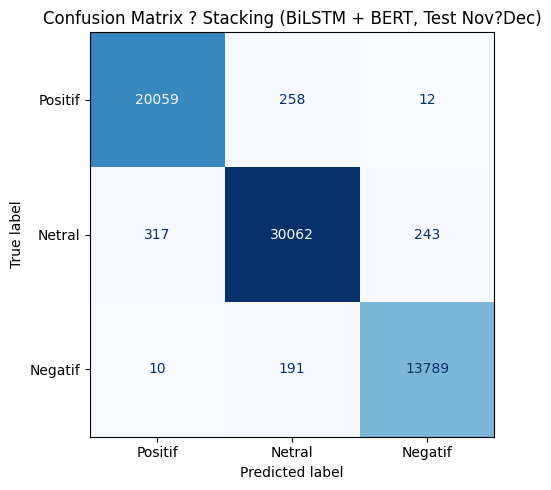


=== Ringkasan hasil di Test (Nov?Dec 2024) ===


,model,accuracy,macro_f1
0,BERT fine-tuned,0.985633,0.985657
1,Stacking BiLSTM+BERT,0.984124,0.984189
2,BiLSTM (BOW vocab),0.979705,0.979793


In [18]:

# ============================================================
# 5) Stacking ensemble: BiLSTM + BERT ? Logistic Regression
# ============================================================

import joblib

# Path file untuk menyimpan hasil Stacking
STACKING_MODEL_PATH = ARTE_DL_DIR / "stacking_meta_lr.joblib"
STACKING_RESULTS_PATH = ARTE_DL_DIR / "stacking_results.json"
STACKING_PROBA_TRAIN_PATH = ARTE_DL_DIR / "stacking_proba_train.npz"
STACKING_PROBA_TEST_PATH = ARTE_DL_DIR / "stacking_proba_test.npz"

full_tr_texts = df_tr["text"].values
full_tr_labels = df_tr["label_id"].values

class BiLSTMDatasetFull(Dataset):
    def __init__(self, texts, labels):
        self.texts = list(texts)
        self.labels = list(labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        seq = text_to_seq(self.texts[idx])
        label = self.labels[idx]
        return {
            "input_ids": torch.tensor(seq, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long),
        }


def build_lstm_loader(texts, labels):
    dataset = BiLSTMDatasetFull(texts, labels)
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE_LSTM,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )


def build_bert_loader(texts, labels, desc=None):
    dataset = BertDataset(texts, labels, desc=desc)
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE_BERT,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )


if (
    STACKING_MODEL_PATH.exists()
    and STACKING_RESULTS_PATH.exists()
    and STACKING_PROBA_TRAIN_PATH.exists()
    and STACKING_PROBA_TEST_PATH.exists()
):
    print("\n" + "=" * 60)
    print("? [STACKING] MODEL SUDAH ADA, LOADING DARI FILE...")
    print("=" * 60)

    stack_clf = joblib.load(STACKING_MODEL_PATH)
    with open(STACKING_RESULTS_PATH, "r") as f:
        stacking_results = json.load(f)

    acc_stack = stacking_results["test_accuracy"]
    f1_stack = stacking_results["test_f1"]

    proba_data = np.load(STACKING_PROBA_TEST_PATH)
    proba_te_lstm = proba_data["lstm"]
    proba_te_bert = proba_data["bert"]

    X_stack_te = np.hstack([proba_te_lstm, proba_te_bert])
    stack_pred_test = stack_clf.predict(X_stack_te)
else:
    print("\n" + "=" * 60)
    print("?? [STACKING] MODEL BELUM ADA, MULAI PROSES STACKING...")
    print("=" * 60)

    train_full_lstm_loader = build_lstm_loader(full_tr_texts, full_tr_labels)
    test_full_lstm_loader = build_lstm_loader(X_test, y_test)

    print("\n?? [STACKING] Step 1/4: Generating BiLSTM probabilities...")
    proba_tr_lstm = predict_proba_lstm(
        lstm_model, train_full_lstm_loader, desc="?? BiLSTM Train Proba"
    )
    proba_te_lstm = predict_proba_lstm(
        lstm_model, test_full_lstm_loader, desc="?? BiLSTM Test Proba"
    )

    train_full_bert_loader = build_bert_loader(
        full_tr_texts,
        full_tr_labels,
        desc="Encoding BERT train set (stacking)",
    )
    test_full_bert_loader = build_bert_loader(
        X_test,
        y_test,
        desc="Encoding BERT test set (stacking)",
    )

    print("\n?? [STACKING] Step 2/4: Generating BERT probabilities...")
    proba_tr_bert = predict_proba_bert(
        bert_model, train_full_bert_loader, desc="?? BERT Train Proba"
    )
    proba_te_bert = predict_proba_bert(
        bert_model, test_full_bert_loader, desc="?? BERT Test Proba"
    )

    assert proba_tr_lstm.shape == proba_tr_bert.shape == (len(full_tr_labels), len(ALL_LABELS))
    assert proba_te_lstm.shape == proba_te_bert.shape == (len(y_test), len(ALL_LABELS))

    print("\n?? [STACKING] Step 3/4: Menyimpan probabilitas...")
    np.savez_compressed(
        STACKING_PROBA_TRAIN_PATH,
        lstm=proba_tr_lstm,
        bert=proba_tr_bert,
    )
    np.savez_compressed(
        STACKING_PROBA_TEST_PATH,
        lstm=proba_te_lstm,
        bert=proba_te_bert,
    )

    X_stack_tr = np.hstack([proba_tr_lstm, proba_tr_bert])
    X_stack_te = np.hstack([proba_te_lstm, proba_te_bert])
    y_stack_tr = full_tr_labels.copy()

    print("\n?? [STACKING] Step 4/4: Training meta-learner (Logistic Regression)...")
    stack_clf = LogisticRegression(
        max_iter=500,
        multi_class="multinomial",
        n_jobs=None,
        class_weight="balanced",
    )
    stack_clf.fit(X_stack_tr, y_stack_tr)

    print("\n?? [STACKING] Predicting on test set...")
    stack_pred_test = stack_clf.predict(X_stack_te)

    acc_stack = accuracy_score(y_test, stack_pred_test)
    f1_stack = f1_score(y_test, stack_pred_test, average="macro")

    print(f"\n?? [STACKING] Menyimpan model ke {STACKING_MODEL_PATH}...")
    joblib.dump(stack_clf, STACKING_MODEL_PATH)

    stacking_results = {
        "test_accuracy": float(acc_stack),
        "test_f1": float(f1_stack),
    }
    with open(STACKING_RESULTS_PATH, "w") as f:
        json.dump(stacking_results, f, indent=2)

    print("\n" + "=" * 60)
    print("? [STACKING] MODEL DAN HASIL TERSIMPAN!")
    print("=" * 60)

print(f"\n[STACKING BiLSTM+BERT] Test Accuracy: {acc_stack:.4f} | Macro-F1: {f1_stack:.4f}")

print("\n[Stacking] Classification report (Test):")
print(
    classification_report(
        y_test,
        stack_pred_test,
        target_names=ALL_LABELS,
        digits=4,
        zero_division=0,
    )
)

cm_stack = confusion_matrix(
    y_test,
    stack_pred_test,
    labels=list(range(len(ALL_LABELS))),
)
disp_stack = ConfusionMatrixDisplay(cm_stack, display_labels=ALL_LABELS)
fig, ax = plt.subplots(figsize=(5.6, 5))
disp_stack.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix ? Stacking (BiLSTM + BERT, Test Nov?Dec)")
plt.tight_layout()
plt.show()

summary = pd.DataFrame(
    [
        {"model": "BiLSTM (BOW vocab)", "accuracy": test_acc_lstm, "macro_f1": test_f1_lstm},
        {"model": "BERT fine-tuned", "accuracy": test_acc_bert, "macro_f1": test_f1_bert},
        {"model": "Stacking BiLSTM+BERT", "accuracy": acc_stack, "macro_f1": f1_stack},
    ]
)

print("\n=== Ringkasan hasil di Test (Nov?Dec 2024) ===")
display(summary.sort_values("macro_f1", ascending=False).reset_index(drop=True))


In [19]:
# ============================================================
# 6) Info artefak model (semua sudah tersimpan otomatis)
# ============================================================

print("\n" + "="*60)
print("📁 ARTEFAK MODEL TERSIMPAN DI:")
print("="*60)
print(f"Folder: {ARTE_DL_DIR.resolve()}")
print("\nFile yang tersimpan:")
print("  ✓ bilstm_bow_model.pt         - Model BiLSTM + vocabulary")
print("  ✓ bilstm_results.json         - Hasil evaluasi BiLSTM")
print("  ✓ bert_model/                 - Model BERT fine-tuned")
print("  ✓ bert_tokenizer/             - Tokenizer BERT")
print("  ✓ bert_results.json           - Hasil evaluasi BERT")
print("  ✓ stacking_meta_lr.joblib     - Meta-learner Logistic Regression")
print("  ✓ stacking_results.json       - Hasil evaluasi Stacking")
print("  ✓ stacking_proba_train.npz    - Probabilitas train (cached)")
print("  ✓ stacking_proba_test.npz     - Probabilitas test (cached)")
print("\n💡 TIPS:")
print("  • Jalankan ulang notebook akan otomatis load model yang sudah ada")
print("  • Tidak perlu retrain jika model sudah tersimpan")
print("  • Hapus file di folder artefacts_2024_window_deep/ jika ingin retrain")
print("="*60)



📁 ARTEFAK MODEL TERSIMPAN DI:
Folder: D:\Machine Learning\Israel-Iran Sentiment Analysis\artefacts_2024_window_deep

File yang tersimpan:
  ✓ bilstm_bow_model.pt         - Model BiLSTM + vocabulary
  ✓ bilstm_results.json         - Hasil evaluasi BiLSTM
  ✓ bert_model/                 - Model BERT fine-tuned
  ✓ bert_tokenizer/             - Tokenizer BERT
  ✓ bert_results.json           - Hasil evaluasi BERT
  ✓ stacking_meta_lr.joblib     - Meta-learner Logistic Regression
  ✓ stacking_results.json       - Hasil evaluasi Stacking
  ✓ stacking_proba_train.npz    - Probabilitas train (cached)
  ✓ stacking_proba_test.npz     - Probabilitas test (cached)

💡 TIPS:
  • Jalankan ulang notebook akan otomatis load model yang sudah ada
  • Tidak perlu retrain jika model sudah tersimpan
  • Hapus file di folder artefacts_2024_window_deep/ jika ingin retrain


In [21]:
%%time

# ============================
# Sanity check BiLSTM & BERT
# ============================

samples = [
    "i totally support this decision, feels like progress!",
    "not sure this is a good idea",
    "this is the worst policy i've ever seen",
]

# -------------------------
# 1) BiLSTM 
# -------------------------
lstm_model.eval()
with torch.no_grad():
    # ubah tiap teks ke sequence ID pakai text_to_seq
    seqs = [text_to_seq(s) for s in samples]          # shape: list [MAX_LEN_LSTM]
    input_ids_lstm = torch.tensor(seqs, dtype=torch.long).to(device)
    
    logits_lstm, _ = lstm_model(input_ids=input_ids_lstm, labels=None)
    probs_lstm = torch.softmax(logits_lstm, dim=-1).cpu().numpy()
    pred_idx_lstm = probs_lstm.argmax(axis=1)
    labels_lstm = [ALL_LABELS[i] for i in pred_idx_lstm]

# ---------------------
# 2) BERT 
# ---------------------
bert_model.eval()
with torch.no_grad():
    encoded = tokenizer(
        samples,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN_BERT,
        return_tensors="pt",
    )
    input_ids_bert = encoded["input_ids"].to(device)
    attn_mask_bert = encoded["attention_mask"].to(device)

    outputs_bert = bert_model(input_ids=input_ids_bert,
                              attention_mask=attn_mask_bert)
    probs_bert = torch.softmax(outputs_bert.logits, dim=-1).cpu().numpy()
    pred_idx_bert = probs_bert.argmax(axis=1)
    labels_bert = [ALL_LABELS[i] for i in pred_idx_bert]

# ---------------------
for s, lab_lstm, lab_bert in zip(samples, labels_lstm, labels_bert):
    print(s)
    print(f"  BiLSTM: {lab_lstm}")
    print(f"  BERT  : {lab_bert}")
    print("-" * 60)


i totally support this decision, feels like progress!
  BiLSTM: Netral
  BERT  : Netral
------------------------------------------------------------
not sure this is a good idea
  BiLSTM: Positif
  BERT  : Positif
------------------------------------------------------------
this is the worst policy i've ever seen
  BiLSTM: Negatif
  BERT  : Negatif
------------------------------------------------------------
CPU times: total: 188 ms
Wall time: 188 ms


<timed exec>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
